# Electric Data Predict

## Colab Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Feb 11 08:43:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Library

In [3]:
!pip install pytorch-lightning

     |████████████████████████████████| 696kB 15.8MB/s 
     |████████████████████████████████| 276kB 54.0MB/s 
     |████████████████████████████████| 102kB 16.3MB/s 
     |████████████████████████████████| 829kB 56.5MB/s 
     |████████████████████████████████| 1.3MB 48.1MB/s 
     |████████████████████████████████| 296kB 53.2MB/s 
     |████████████████████████████████| 143kB 56.5MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=0fef71e9958fe8ec681e96ffe167b7cc66ad1b1b8941cb0cd1bd62baf2ebd38d
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=0d2d0a56618310502650b338ee987683d176a2ab6a80ab90db556be7be0acd4e
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=316

In [4]:
%cd drive/MyDrive/Research3/train

/content/drive/MyDrive/Research3/train


In [5]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

import pytorch_lightning as pl
from pytorch_lightning import loggers, callbacks
from pytorch_lightning.metrics import functional as FM

import GetData
from BaseModel import BaseModel

## Define Model

In [7]:
class Model(BaseModel):
    def __init__(self, rnn, n_y, n_input, n_hidden, n_output, n_layers, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.n_output = n_output
        self.n_y = n_y
        
        self.en = rnn(n_input, n_hidden, num_layers=n_layers, batch_first=True)
        self.de = rnn(n_input, n_hidden, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_output)
        
    def forward(self, X):
        batch_size = X.shape[0]
        E, h = self.en(X)

        d = X[:, -1, :]
        output = torch.empty((batch_size, self.n_y), device=self.device)
        
        for i in range(self.n_y):
            d, h = self.de(d.view(-1, 1, 1), h)
            d = self.fc(torch.squeeze(d, 1))
            output[:, i] = torch.squeeze(d, 1)
        
        return output
    
    def test_epoch_end(self, outputs):
        h, y = zip(*outputs)
        h = torch.cat(h, 0).cpu().numpy()
        y = torch.cat(y, 0).cpu().numpy()
        plt.scatter(y, h, s=1)
        plt.show()

In [63]:
class BaseLine(BaseModel):
    def __init__(self, n_x, n_y, n_hidden, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_x = n_x
        self.fc = nn.Sequential(
            nn.Linear(n_x, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, n_y)
        )
        
    def forward(self, X):
        return self.fc(X.view(-1, self.n_x))
    
    def test_epoch_end(self, outputs):
        h, y = zip(*outputs)
        h = torch.cat(h, 0).cpu().numpy()
        y = torch.cat(y, 0).cpu().numpy()
        plt.scatter(y, h, s=1)
        plt.show()

## Train And Predict

In [64]:
n_X = 24*30
n_y = 24
batch_size = 128
ex_name = 'electric'
metrics_fn = [(FM.mean_absolute_error, 'mae')]
tb_logger = loggers.TensorBoardLogger('TB_logs', name=ex_name)
csv_logger = loggers.CSVLogger('CSV_logs', name=ex_name)
loggers_arr = [tb_logger, csv_logger]

In [65]:
data_module = GetData.ElectricData(n_X, n_y, batch_size=batch_size, shuffle=False)
#model = Model(nn.GRU, n_y, 1, 16, 1, 1, F.mse_loss, metrics_fn=metrics_fn)
model = BaseLine(n_X, n_y, 6*30, F.mse_loss, metrics_fn=metrics_fn)
trainer = pl.Trainer(gpus=1, max_epochs=500, progress_bar_refresh_rate=30, logger=loggers_arr, weights_save_path='lightning_logs')

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [66]:
trainer.fit(model, datamodule=data_module)


  | Name | Type       | Params
------------------------------------
0 | fc   | Sequential | 166 K 
------------------------------------
166 K     Trainable params
0         Non-trainable params
166 K     Total params


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

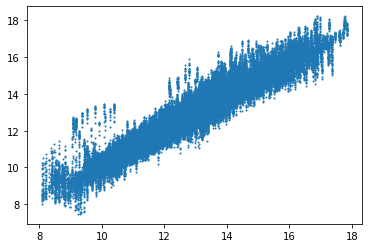


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss/test': 0.2074921578168869, 'mae/test': 0.32376405596733093}
--------------------------------------------------------------------------------


[{'loss/test': 0.2074921578168869, 'mae/test': 0.32376405596733093}]

In [67]:
trainer.test(datamodule=data_module)

In [50]:
X, Y = next(iter(data_module.test_dataloader()))

In [68]:
with torch.no_grad():
  T = model(X.cuda()).cpu()

In [52]:
def p(i):
  plt.plot(T[i])
  plt.plot(Y[i])
  plt.show()

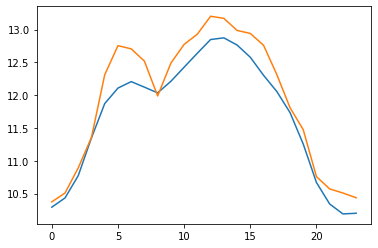

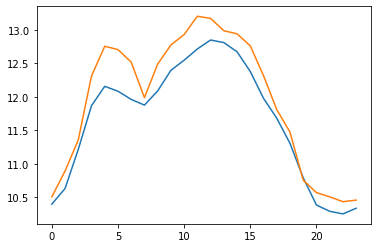

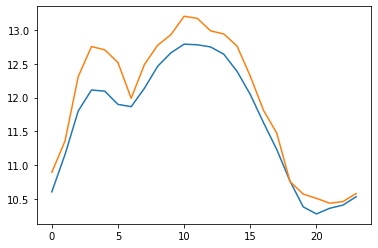

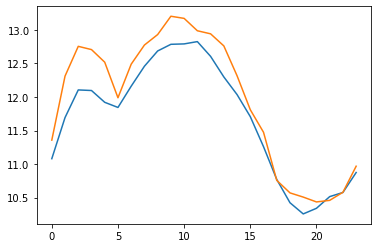

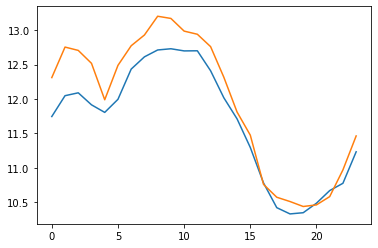

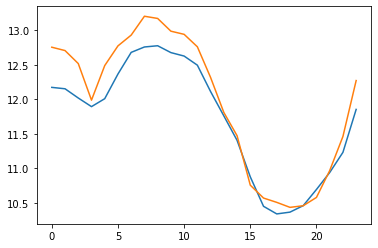

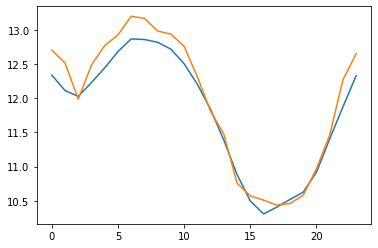

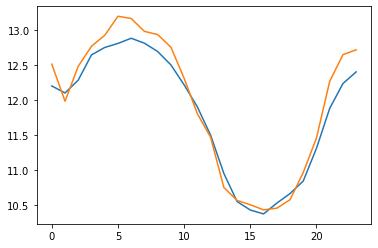

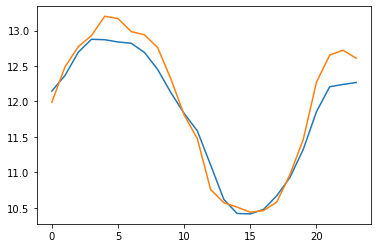

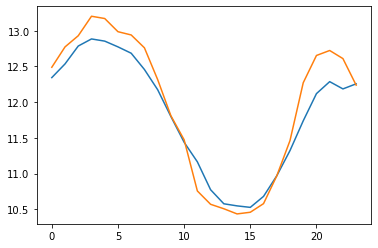

In [69]:
for i in range(50, 60):
  p(i)